# LSTM Production
Notebook to put LSTM into production on AWS

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sqlalchemy
from sqlalchemy import create_engine
import s3fs
import gc

from functools import partial
import ray
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.stopper import TrialPlateauStopper

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from dotenv import load_dotenv

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model

In [2]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size=8, num_lstm_layers=1, dropout=0):
        super().__init__()
        if num_lstm_layers == 1:
            dropout = 0
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out)
        return x

### Train Function

In [3]:
def train_lstm(config, train_X, train_y, val_X, val_y, checkpoint_dir=None,):

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    
    print(f"DEVICE: {device}")
    train_X = train_X.to(device)
    train_y = train_y.to(device)
    val_X = val_X.to(device)
    val_y = val_y.to(device)
    
    # Configure the network and send it to the device
    # Width of the dataframe - 1 (y variable) is feature set size 
    input_size = train_X.shape[2]
    net = Net(input_size=input_size,
              hidden_size=config['hidden_size'],
              num_lstm_layers=config['num_lstm_layers'],
              dropout=config['dropout'])
    
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)     
    net.to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=config['learning_rate'])
    optimizer
    
    # Checkpoint Dir Stuff -- handled by Tune 
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)    
    
    # train
    BATCH_SIZE = config['batch_size']
    for epoch in range(1000):
        epoch_start = datetime.now()
        print(f"Epoch: {epoch}")
        running_loss = 0
        epoch_steps = 0
        for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
            X = train_X[i:i+BATCH_SIZE]
            y = train_y[i:i+BATCH_SIZE]
            net.zero_grad()
            
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1
            
            # Print loss every 1000 batches
            if i % 100 == 99:
                avg_loss = running_loss / epoch_steps
                print(f"Epoch {epoch}, steps {epoch_steps-1000}:{epoch_steps} avg loss: {avg_loss}")
                running_loss = 0 
                
        # Validate each epoch
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
                X = val_X[i:i+BATCH_SIZE]
                y = val_y[i:i+BATCH_SIZE]
                out_seq = net(X)
                first_dim, second_dim, _ = out_seq.shape
                pred = out_seq.view(first_dim, second_dim)[:, -1]
                loss = F.mse_loss(pred, y)
                val_loss += loss.item()
                val_steps += 1
        
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            
        tune.report(val_loss=(val_loss/val_steps), train_loss=(running_loss/epoch_steps), training_iteration=epoch)
        print(f"Finished epoch {epoch} in {datetime.now()-epoch_start}")
    print("finished!")

### Load and Process data

In [2]:
os.path.exists("./test_X.pt")

True

In [3]:
s3 = s3fs.S3FileSystem()
string = "loading train X"
if os.path.exists("./train_X.pt"):
    print(f"{string}locally")
    with open("./train_X.pt", 'rb') as f:
        train_X = torch.load(f)
else:
    print(f"{string}remotely")
    with s3.open("s3://bgpredict/models/lstm/tensors/train_X", 'rb') as f:
        train_X=torch.load(f)
        
string = "loading train y "
if os.path.exists("./train_y.pt"):
    print(f"{string}locally")
    with open("./train_y.pt", "rb") as f:
        train_y = torch.load(f)
else:
    print(f"{string}remotely")
    with s3.open("s3://bgpredict/models/lstm/tensors/train_y", 'rb') as f:
        train_y=torch.load(f)

string = "loading val X"
if os.path.exists("./val_X.pt"):
    print(f"{string}locally")
    with open("./val_X.pt", 'rb') as f:
        val_X = torch.load(f)
else:
    print(f"{string}remotely")
    with s3.open("s3://bgpredict/models/lstm/tensors/val_X", 'rb') as f:
        val_X=torch.load(f) 

string = "loading val y"
if os.path.exists("./val_y.pt"):
    print(f"{string}locally")
    with open("./val_y.pt", 'rb') as f:
        val_y = torch.load(f)
else:
    print(f"{string}remotely")
    with s3.open("s3://bgpredict/models/lstm/tensors/val_y", 'rb') as f:
        val_y=torch.load(f)    

loading train Xlocally
loading train y locally
loading val Xlocally
loading val ylocally


In [4]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

torch.Size([2822590, 12, 30])
torch.Size([2822590])
torch.Size([1346613, 12, 30])
torch.Size([1346613])


In [5]:
torch.cuda.is_available()

True

In [45]:
ray.shutdown()
ray.init()

RayContext(dashboard_url='', python_version='3.9.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '172.31.11.119', 'raylet_ip_address': '172.31.11.119', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-29_02-23-17_304451_17341/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-29_02-23-17_304451_17341/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-07-29_02-23-17_304451_17341', 'metrics_export_port': 64048, 'gcs_address': '172.31.11.119:58825', 'address': '172.31.11.119:58825', 'node_id': '887a7277d743759952ed30ec307ee2d9ce789d60833201e715df11ea'})

In [ ]:
config= {
    'hidden_size': tune.choice([2**x for x in range(3, 8)]), # 2^3 to 2^8, 8 to 256
    'num_lstm_layers':tune.choice([1,2,3]),
    'dropout': tune.choice([0, 0.1, 0.2, 0.3, 0.4, 0.5]), # [0,0.5]
    'learning_rate': tune.choice([0.0001, 0.001, 0.01, 0.1]),
    'batch_size': tune.choice([64, 128, 256]), # 2^3 to 2^8, 8 to 256
}

initial_params = [{"hidden_size": 128,
                  "num_lstm_layers": 1,
                  "dropout": 0,
                  "batch_size": 256,
                  'learning_rate': 0.1}]

def stopper(trial_id, result):
    train_times = [10 * i for i in range(11)]
    if result['training_iteration'] < 100: # and result["training_iteration"] > 10:
        training_iteration = result['training_iteration']
        ceiling = (np.log(training_iteration) ** -0.7) * 2 * 4000
        print(f"CEILING: {ceiling}, ITER_NUM: {result['training_iteration']}")
        if result['val_loss'] > ceiling:
            return True
    elif result['training_iteration'] > 100:
        return True
    elif result['val_loss'] < 90:
        return True
    else:
        return False


hyperopt_search = HyperOptSearch(metric='val_loss', mode='min', points_to_evaluate=initial_params)

scheduler = ASHAScheduler(
    metric="val_loss",
    mode="min",
    grace_period=3,
    max_t=200
)

reporter = JupyterNotebookReporter(
    metric_columns = ["val_loss", "loss", "training_iteration"],
    overwrite=False,
    max_report_frequency=60
)


result = tune.run(
    tune.with_parameters(
        train_lstm,
        train_X = train_X,
        train_y = train_y,
        val_X = val_X,
        val_y = val_y
    ),
    resources_per_trial={"cpu":10, "gpu":4},
    config=config,
    num_samples=1,
    search_alg=hyperopt_search,
    name='GPU',
    stop = stopper,
    resume = "ERRORED_ONLY",
)

In [154]:
best_trial =result.get_best_trial(metric='val_loss', mode='min', scope="last-5-avg")

In [155]:
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))

Best trial config: {'hidden_size': 256, 'num_lstm_layers': 2, 'dropout': 0.3, 'learning_rate': 0.0001, 'batch_size': 256}
Best trial final validation loss: 288.95336100973554


In [186]:
best_dir = result.get_best_logdir(metric='val_loss', mode='min')
df = pd.read_csv(f"{best_dir}/progress.csv")
print(f"{best_dir}/progress.csv")
df.head()

/home/ec2-user/ray_results/GPU/train_lstm_6cfa9ec2_58_batch_size=256,dropout=0.3000,hidden_size=256,learning_rate=0.0001,num_lstm_layers=2_2022-07-29_09-27-48/progress.csv


,val_loss,train_loss,training_iteration,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,trial_id,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time
0,2564.141468,5408.201329,0,236.179984,True,False,NaN,NaN,6cfa9ec2,d8133fb3b06e4790bcc45256dcc07329,2022-07-29_09-31-46,1659087106,236.179984,43753,ip-172-31-11-119.us-west-2.compute.internal,172.31.11.119,236.179984,0,1,0.002463
1,2564.046755,2541.210943,1,222.899053,True,False,NaN,NaN,6cfa9ec2,d8133fb3b06e4790bcc45256dcc07329,2022-07-29_09-35-29,1659087329,459.079037,43753,ip-172-31-11-119.us-west-2.compute.internal,172.31.11.119,459.079037,0,2,0.002463
2,2161.225864,2414.365723,2,219.613094,True,False,NaN,NaN,6cfa9ec2,d8133fb3b06e4790bcc45256dcc07329,2022-07-29_09-39-08,1659087548,678.692131,43753,ip-172-31-11-119.us-west-2.compute.internal,172.31.11.119,678.692131,0,3,0.002463
3,1818.287905,2051.091033,3,219.261975,True,False,NaN,NaN,6cfa9ec2,d8133fb3b06e4790bcc45256dcc07329,2022-07-29_09-42-48,1659087768,897.954105,43753,ip-172-31-11-119.us-west-2.compute.internal,172.31.11.119,897.954105,0,4,0.002463
4,1273.295188,1428.743554,4,217.874669,True,False,NaN,NaN,6cfa9ec2,d8133fb3b06e4790bcc45256dcc07329,2022-07-29_09-46-25,1659087985,1115.828774,43753,ip-172-31-11-119.us-west-2.compute.internal,172.31.11.119,1115.828774,0,5,0.002463


In [140]:
dfs = result.trial_dataframes

In [66]:
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.val_loss.plot(ax=ax, legend=False, figsize=(20,10))
ax.axhline(y=500)

NameError: name 'dfs' is not defined

In [7]:
best_trial = {'hidden_size': 32, 'num_lstm_layers': 1, 'dropout': 0, 'learning_rate': 0.001, 'batch_size': 256}

In [8]:
net = Net(input_size=train_X.shape[2], 
          hidden_size = best_trial['hidden_size'],
          num_lstm_layers=best_trial['num_lstm_layers'],
          dropout= best_trial['dropout']
)
net

Net(
  (lstm): LSTM(30, 32)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)

In [9]:
torch.cuda.memory_allocated()/1024/1024

0.0

In [10]:
losses = []
val_losses = []
BATCH_SIZE = best_trial['batch_size']
learning_rate = best_trial['learning_rate']
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
iter_idx = 0 
running_loss = 0
running_val_loss = 0
epoch_steps = 0
epoch = 0 

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

print(f"DEVICE: {device}")
if torch.cuda.device_count() > 1:
    print(f"Running in Parallel on {torch.cuda.device_count()} GPU's")
    net = nn.DataParallel(net)     
net.to(device)


DEVICE: cuda:0
Running in Parallel on 4 GPU's


DataParallel(
  (module): Net(
    (lstm): LSTM(30, 32)
    (fc1): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
while True:
    start = datetime.now()
    print(f"Epoch: {epoch}")
    epoch_loss = []
    for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
        X = train_X[i:i+BATCH_SIZE].to(device)
        y = train_y[i:i+BATCH_SIZE].to(device)
        net.zero_grad()

        out_seq = net(X)
        first_dim, second_dim, _ = out_seq.shape
        pred = out_seq.view(first_dim, second_dim)[:, -1]
        loss = F.mse_loss(pred, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * BATCH_SIZE
        epoch_steps += 1
        
    # Compute Epoch Training Loss
    epoch_train_loss = running_loss / train_X.shape[0]
    losses.append(epoch_train_loss)
    
    # Compute Validation Loss
    val_loss = []
    val_steps = 0
    with torch.no_grad():
        for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
            X = val_X[i:i+BATCH_SIZE].to(device)
            y = val_y[i:i+BATCH_SIZE].to(device)
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            running_val_loss += loss.item() * BATCH_SIZE
            val_steps += 1
    
    # Compute validation loss
    epoch_val_loss = running_val_loss / val_X.shape[0]
    val_losses.append(epoch_val_loss)
        
    mean_trailing_loss = np.mean(val_losses[-10:])
    # Print Results 
    print(f"Epoch {epoch} finished in {datetime.now()-start}| Train Loss: {epoch_train_loss} | Batch AVG(Validation) Loss: {epoch_val_loss} | Trailing Loss: {mean_trailing_loss}")   
    running_loss = 0 
    running_val_loss = 0 
    epoch_steps = 0 
    epoch += 1
        
    # Break if we've not improved in 10 iterations or reach 200 epochs 
    if epoch_val_loss > (mean_trailing_loss + 0.1 * mean_trailing_loss) and epoch > 10:
        print("Breaking with plateaued loss")
        break
    if epoch >=200:
        break
        



Epoch: 0
Epoch 0 finished in 0:01:10.090170| Train Loss: 4989.90412103777 | Batch AVG(Validation) Loss: 2574.0352219849447 | Trailing Loss: 2574.0352219849447
Epoch: 1
Epoch 1 finished in 0:01:03.522494| Train Loss: 2541.2378107767377 | Batch AVG(Validation) Loss: 2458.460211158013 | Trailing Loss: 2516.247716571479
Epoch: 2
Epoch 2 finished in 0:01:04.196812| Train Loss: 2350.5842827227166 | Batch AVG(Validation) Loss: 2200.6050874388766 | Trailing Loss: 2411.0335068606114
Epoch: 3
Epoch 3 finished in 0:01:04.615816| Train Loss: 2274.8908121591116 | Batch AVG(Validation) Loss: 2177.5540928338587 | Trailing Loss: 2352.663653353923
Epoch: 4
Epoch 4 finished in 0:01:04.711683| Train Loss: 2256.243190530738 | Batch AVG(Validation) Loss: 2071.2832596789244 | Trailing Loss: 2296.3875746189233
Epoch: 5
Epoch 5 finished in 0:01:04.909020| Train Loss: 2247.64080094656 | Batch AVG(Validation) Loss: 2027.2956512062578 | Trailing Loss: 2251.5389207168123
Epoch: 6
Epoch 6 finished in 0:01:07.05287

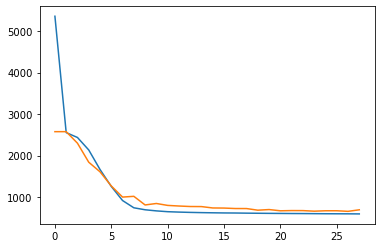

In [43]:
plt.plot(losses)
plt.plot(val_losses)

In [20]:
with open("./test_X.pt", 'rb') as f:
    test_X = torch.load(f)
with open("./test_y.pt", 'rb') as f:
    test_y = torch.load(f)

In [70]:
net.eval()
with torch.no_grad():
    out_seq = net(test_X)
    first_dim, second_dim, _ = out_seq.shape
    pred = out_seq.view(first_dim, second_dim)[:, -1]

RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu

In [72]:
torch.save(net.state_dict(), "./big_model.pt")

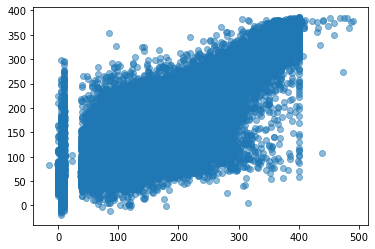

In [59]:
pred_array = pred.cpu().detach().numpy()
y = test_y.detach().numpy()
plt.scatter(y, pred_array, alpha=0.5)

In [ ]:
plt.hist(y, bins=100)

In [68]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0001,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [47]:
mse = mean_squared_error(y, pred_array)
print(np.sqrt(mse))

18.850718


In [48]:
mean_absolute_percentage_error(y, pred_array)

35034280000000.0

In [49]:
mean_absolute_error(y,pred_array)

13.416581